# Approximate a well known numerical function 

## $f(x)=\cos(x)$



Neural Networks are known not to generalize well on extrapolation of simple mathematical functions such as addition or multiplication, or let's say cosine of a value, for example see below:

In [1]:
#setup
import itertools
import numpy as np
from math import sqrt
import pylab as pl
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error
%matplotlib inline

def plot_result(y_test, y_pred):
    rms = sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rms}")
    
    pl.subplot(211)
    pl.plot(y_pred, 'b' ,label='predicted')
    pl.plot(y_test, 'm', label='actual')
    pl.xlabel('#')
    pl.ylabel('(cos(x) + 1) / 2')
    pl.legend()
    pl.subplot(212)
    pl.plot(y_pred - y_test, 'r' , label='diff')    
    pl.ylabel('error')
    pl.legend()
    pl.show()

Using TensorFlow backend.


In [2]:
#gather data
# adopting the generate static dataset for radial uniary functions
def generate_static_radial_dataset(op_fn, num_samples=1000, mode='interpolation',
                            seed=0, cycles=1, theta_offset=2.0 * np.pi):
    """
    Generates a dataset given an operation and a mode of working.
    Used to generate the synthetic static dataset.

    # Arguments:
        op_fn: A function which accepts single numpy array as arguments
            and returns a single numpy array as the result.
        num_samples: Number of samples for the dataset.
        mode: Can be one of `interpolation` or `extrapolation`
        seed: random seed

    Returns:

    """
    assert mode in ['interpolation', 'extrapolation']
    assert callable(op_fn)

    np.random.seed(seed)  # make deterministic

    print("Generating dataset")

    # Get the input stream
    X = np.linspace(0.0, cycles * 2.0 * np.pi, num_samples).reshape(-1, 1)

    # linearly shift cycles by 2pi
    if mode == 'extrapolation':
        X += theta_offset

    # perform the operation on the slices in order to get the target
    Y = op_fn(X)

    return X, Y





In [3]:
#data points across radial axis
# cycles = 1 # 2
# X = np.linspace(0.0, cycles * 2.0 * np.pi, 5000).reshape(-1, 1)

# #function to approximate
# y = (np.cos(X) + 1)/2 # note: activatation functions work better in the range of [0,1] rather than [-1,1]
task_name = 'cosine'
task_fn = lambda x: (np.cos(x)+1) / 2
X, y = generate_static_radial_dataset(task_fn, 5000, mode='interpolation', seed=0, cycles=1)

Generating dataset


RMSE: 0.034586792263959026


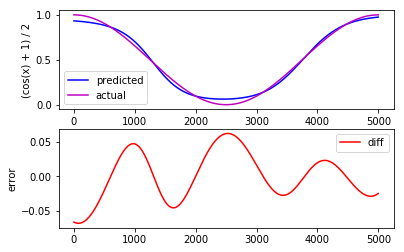

In [4]:
simple_model = None

#create
simple_model = Sequential()

#add
simple_model.add(Dense(6, input_dim=X.shape[1], kernel_initializer='normal', activation='sigmoid'))
#model.add(Dense(6, kernel_initializer='normal', activation='sigmoid'))
simple_model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

#compile
simple_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

#fit
simple_model.fit(X, y, epochs=250, batch_size=32, verbose=0) #change verbosity for showing progress
#model.fit(X, y, epochs=10000, batch_size=32, verbose=0) #change verbosity for showing progress

#predict
y_pred = simple_model.predict(X, batch_size=32)

#visualize
plot_result(y,y_pred)

<img src="NALU_paper.jpg">

## Paper: https://arxiv.org/abs/1808.00508
## Keras Implementation :https://github.com/titu1994/keras-neural-alu

In [7]:
#run only once! Note: Tested on Windows
!git clone https://github.com/titu1994/keras-neural-alu
#rename for ease of importing
!rename keras-neural-alu KerasNeuralALU
#make it a module
!echo # -*- coding: utf-8 -*- > KerasNeuralALU/__init__.py

Cloning into 'keras-neural-alu'...


Generating dataset
Generating dataset


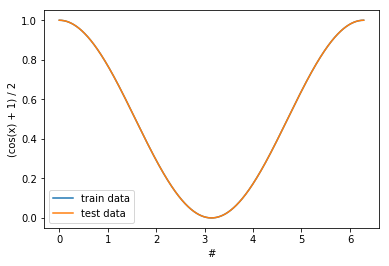

In [5]:
#TODO code here for cos(x) approximation with NALU layer

# hyper parameters
units = 2
num_samples = 1000

task_name = 'cosine'
task_fn = lambda x: (np.cos(x)+1) / 2

X_train, y_train = generate_static_radial_dataset(task_fn, num_samples, mode='interpolation', seed=0, cycles=1)
X_test, y_test = generate_static_radial_dataset(task_fn, num_samples, mode='extrapolation', seed=0, cycles=1, theta_offset=0.0*np.pi)

pl.plot(X_train, y_train, label='train data')
pl.plot(X_test, y_test, label='test data')
pl.xlabel('#')
pl.ylabel('(cos(x) + 1) / 2')
pl.legend()
pl.show()

In [6]:
from KerasNeuralALU.nalu import NALU

# generate the model
ip = Input(shape=(1,))
x = NALU(units)(ip)
x = NALU(1)(x)

nalu_model = Model(ip, x)
nalu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
nalu_1 (NALU)                (None, 24)                72        
_________________________________________________________________
nalu_2 (NALU)                (None, 24)                1728      
_________________________________________________________________
nalu_3 (NALU)                (None, 1)                 72        
Total params: 1,872
Trainable params: 1,872
Non-trainable params: 0
_________________________________________________________________


In [7]:
# compile
optimizer = RMSprop(0.1)
nalu_model.compile(optimizer, 'mse')

In [8]:
nalu_model.fit(X_train, y_train, batch_size=64, epochs=2000, verbose=2, validation_data=(X_test, y_test))

Train on 1000 samples, validate on 1000 samples
Epoch 1/2000
 - 0s - loss: 288.6558 - val_loss: 0.8637
Epoch 2/2000
 - 0s - loss: 0.4419 - val_loss: 0.2955
Epoch 3/2000
 - 0s - loss: 0.5572 - val_loss: 0.1885
Epoch 4/2000
 - 0s - loss: 0.2246 - val_loss: 0.1378
Epoch 5/2000
 - 0s - loss: 0.1163 - val_loss: 0.0674
Epoch 6/2000
 - 0s - loss: 0.0596 - val_loss: 0.0646
Epoch 7/2000
 - 0s - loss: 0.2051 - val_loss: 0.1564
Epoch 8/2000
 - 0s - loss: 0.1561 - val_loss: 0.0563
Epoch 9/2000
 - 0s - loss: 0.0663 - val_loss: 0.1593
Epoch 10/2000
 - 0s - loss: 0.5340 - val_loss: 0.3251
Epoch 11/2000
 - 0s - loss: 0.3140 - val_loss: 0.2636
Epoch 12/2000
 - 0s - loss: 0.2582 - val_loss: 0.1367
Epoch 13/2000
 - 0s - loss: 0.1767 - val_loss: 0.1298
Epoch 14/2000
 - 0s - loss: 0.1762 - val_loss: 0.1650
Epoch 15/2000
 - 0s - loss: 1.6981 - val_loss: 493661.3041
Epoch 16/2000
 - 0s - loss: 769497.2942 - val_loss: 0.3193
Epoch 17/2000
 - 0s - loss: 0.3217 - val_loss: 0.3055
Epoch 18/2000
 - 0s - loss: 0.2

Epoch 151/2000
 - 0s - loss: 0.0042 - val_loss: 0.0029
Epoch 152/2000
 - 0s - loss: 0.0040 - val_loss: 0.0033
Epoch 153/2000
 - 0s - loss: 0.0036 - val_loss: 0.0026
Epoch 154/2000
 - 0s - loss: 0.0055 - val_loss: 0.0042
Epoch 155/2000
 - 0s - loss: 0.0031 - val_loss: 0.0149
Epoch 156/2000
 - 0s - loss: 0.0047 - val_loss: 0.0040
Epoch 157/2000
 - 0s - loss: 0.0040 - val_loss: 0.0057
Epoch 158/2000
 - 0s - loss: 0.0041 - val_loss: 0.0055
Epoch 159/2000
 - 0s - loss: 0.0037 - val_loss: 0.0078
Epoch 160/2000
 - 0s - loss: 0.0051 - val_loss: 0.0062
Epoch 161/2000
 - 0s - loss: 0.0039 - val_loss: 0.0097
Epoch 162/2000
 - 0s - loss: 0.0058 - val_loss: 0.0021
Epoch 163/2000
 - 0s - loss: 0.0026 - val_loss: 8.3678e-04
Epoch 164/2000
 - 0s - loss: 0.0036 - val_loss: 9.1926e-04
Epoch 165/2000
 - 0s - loss: 0.0030 - val_loss: 0.0137
Epoch 166/2000
 - 0s - loss: 0.0029 - val_loss: 0.0016
Epoch 167/2000
 - 0s - loss: 0.0038 - val_loss: 0.0064
Epoch 168/2000
 - 0s - loss: 0.0047 - val_loss: 9.8375e-0

Epoch 299/2000
 - 0s - loss: 0.0031 - val_loss: 0.0033
Epoch 300/2000
 - 0s - loss: 0.0026 - val_loss: 0.0021
Epoch 301/2000
 - 0s - loss: 0.0023 - val_loss: 0.0015
Epoch 302/2000
 - 0s - loss: 0.0030 - val_loss: 0.0053
Epoch 303/2000
 - 0s - loss: 0.0025 - val_loss: 0.0013
Epoch 304/2000
 - 0s - loss: 0.0024 - val_loss: 0.0020
Epoch 305/2000
 - 0s - loss: 0.0030 - val_loss: 0.0027
Epoch 306/2000
 - 0s - loss: 0.0025 - val_loss: 0.0011
Epoch 307/2000
 - 0s - loss: 0.0030 - val_loss: 9.9456e-04
Epoch 308/2000
 - 0s - loss: 0.0014 - val_loss: 0.0045
Epoch 309/2000
 - 0s - loss: 0.0024 - val_loss: 0.0043
Epoch 310/2000
 - 0s - loss: 0.0032 - val_loss: 0.0017
Epoch 311/2000
 - 0s - loss: 0.0020 - val_loss: 0.0032
Epoch 312/2000
 - 0s - loss: 0.0025 - val_loss: 0.0014
Epoch 313/2000
 - 0s - loss: 0.0024 - val_loss: 0.0015
Epoch 314/2000
 - 0s - loss: 0.0028 - val_loss: 0.0018
Epoch 315/2000
 - 0s - loss: 0.0028 - val_loss: 0.0011
Epoch 316/2000
 - 0s - loss: 0.0022 - val_loss: 0.0012
Epoch 

Epoch 447/2000
 - 0s - loss: 0.0024 - val_loss: 0.0021
Epoch 448/2000
 - 0s - loss: 0.0024 - val_loss: 7.4384e-04
Epoch 449/2000
 - 0s - loss: 0.0019 - val_loss: 5.3336e-04
Epoch 450/2000
 - 0s - loss: 0.0025 - val_loss: 4.8693e-04
Epoch 451/2000
 - 0s - loss: 0.0021 - val_loss: 6.3072e-04
Epoch 452/2000
 - 0s - loss: 0.0022 - val_loss: 0.0013
Epoch 453/2000
 - 0s - loss: 0.0023 - val_loss: 8.9682e-04
Epoch 454/2000
 - 0s - loss: 0.0022 - val_loss: 0.0011
Epoch 455/2000
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 456/2000
 - 0s - loss: 0.0019 - val_loss: 0.0023
Epoch 457/2000
 - 0s - loss: 0.0023 - val_loss: 0.0012
Epoch 458/2000
 - 0s - loss: 0.0023 - val_loss: 0.0035
Epoch 459/2000
 - 0s - loss: 0.0019 - val_loss: 0.0033
Epoch 460/2000
 - 0s - loss: 0.0015 - val_loss: 0.0033
Epoch 461/2000
 - 0s - loss: 0.0016 - val_loss: 0.0020
Epoch 462/2000
 - 0s - loss: 0.0026 - val_loss: 6.2210e-04
Epoch 463/2000
 - 0s - loss: 0.0020 - val_loss: 0.0014
Epoch 464/2000
 - 0s - loss: 0.0023 - val

Epoch 593/2000
 - 0s - loss: 0.0013 - val_loss: 0.0027
Epoch 594/2000
 - 0s - loss: 0.0023 - val_loss: 0.0033
Epoch 595/2000
 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 596/2000
 - 0s - loss: 0.0014 - val_loss: 0.0057
Epoch 597/2000
 - 0s - loss: 0.0025 - val_loss: 6.3533e-04
Epoch 598/2000
 - 0s - loss: 0.0031 - val_loss: 0.0011
Epoch 599/2000
 - 0s - loss: 7.9862e-04 - val_loss: 0.0034
Epoch 600/2000
 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 601/2000
 - 0s - loss: 0.0014 - val_loss: 0.0043
Epoch 602/2000
 - 0s - loss: 0.0022 - val_loss: 0.0021
Epoch 603/2000
 - 0s - loss: 0.0018 - val_loss: 0.0017
Epoch 604/2000
 - 0s - loss: 0.0023 - val_loss: 9.0604e-04
Epoch 605/2000
 - 0s - loss: 0.0016 - val_loss: 6.8101e-04
Epoch 606/2000
 - 0s - loss: 0.0017 - val_loss: 0.0045
Epoch 607/2000
 - 0s - loss: 0.0020 - val_loss: 0.0018
Epoch 608/2000
 - 0s - loss: 0.0029 - val_loss: 0.0015
Epoch 609/2000
 - 0s - loss: 0.0013 - val_loss: 5.9844e-04
Epoch 610/2000
 - 0s - loss: 0.0021 - val_los

Epoch 739/2000
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 740/2000
 - 0s - loss: 0.0021 - val_loss: 0.0012
Epoch 741/2000
 - 0s - loss: 0.0015 - val_loss: 0.0019
Epoch 742/2000
 - 0s - loss: 0.0020 - val_loss: 0.0029
Epoch 743/2000
 - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 744/2000
 - 0s - loss: 0.0020 - val_loss: 5.6662e-04
Epoch 745/2000
 - 0s - loss: 0.0020 - val_loss: 7.1076e-04
Epoch 746/2000
 - 0s - loss: 0.0018 - val_loss: 8.5302e-04
Epoch 747/2000
 - 0s - loss: 0.0019 - val_loss: 0.0029
Epoch 748/2000
 - 0s - loss: 0.0017 - val_loss: 6.9861e-04
Epoch 749/2000
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 750/2000
 - 0s - loss: 0.0016 - val_loss: 8.4503e-04
Epoch 751/2000
 - 0s - loss: 0.0019 - val_loss: 5.8938e-04
Epoch 752/2000
 - 0s - loss: 0.0022 - val_loss: 0.0014
Epoch 753/2000
 - 0s - loss: 0.0019 - val_loss: 8.1685e-04
Epoch 754/2000
 - 0s - loss: 0.0016 - val_loss: 0.0050
Epoch 755/2000
 - 0s - loss: 0.0015 - val_loss: 0.0031
Epoch 756/2000
 - 0s - loss: 0.0020 -

Epoch 885/2000
 - 0s - loss: 0.0015 - val_loss: 4.7403e-04
Epoch 886/2000
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 887/2000
 - 0s - loss: 0.0017 - val_loss: 0.0014
Epoch 888/2000
 - 0s - loss: 0.0016 - val_loss: 0.0030
Epoch 889/2000
 - 0s - loss: 0.0015 - val_loss: 0.0019
Epoch 890/2000
 - 0s - loss: 0.0021 - val_loss: 0.0014
Epoch 891/2000
 - 0s - loss: 0.0013 - val_loss: 0.0015
Epoch 892/2000
 - 0s - loss: 0.0018 - val_loss: 8.1078e-04
Epoch 893/2000
 - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 894/2000
 - 0s - loss: 0.0016 - val_loss: 4.8844e-04
Epoch 895/2000
 - 0s - loss: 0.0018 - val_loss: 6.2954e-04
Epoch 896/2000
 - 0s - loss: 0.0016 - val_loss: 8.9568e-04
Epoch 897/2000
 - 0s - loss: 0.0017 - val_loss: 8.4276e-04
Epoch 898/2000
 - 0s - loss: 0.0014 - val_loss: 0.0023
Epoch 899/2000
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 900/2000
 - 0s - loss: 0.0017 - val_loss: 6.9688e-04
Epoch 901/2000
 - 0s - loss: 0.0016 - val_loss: 0.0027
Epoch 902/2000
 - 0s - loss: 0.0016 -

Epoch 1029/2000
 - 0s - loss: 0.0013 - val_loss: 0.0022
Epoch 1030/2000
 - 0s - loss: 0.0014 - val_loss: 7.0533e-04
Epoch 1031/2000
 - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 1032/2000
 - 0s - loss: 0.0014 - val_loss: 8.5377e-04
Epoch 1033/2000
 - 0s - loss: 0.0021 - val_loss: 0.0031
Epoch 1034/2000
 - 0s - loss: 0.0012 - val_loss: 0.0023
Epoch 1035/2000
 - 0s - loss: 0.0017 - val_loss: 7.1850e-04
Epoch 1036/2000
 - 0s - loss: 0.0013 - val_loss: 0.0010
Epoch 1037/2000
 - 0s - loss: 0.0022 - val_loss: 5.0844e-04
Epoch 1038/2000
 - 0s - loss: 0.0016 - val_loss: 7.1539e-04
Epoch 1039/2000
 - 0s - loss: 0.0011 - val_loss: 3.7209e-04
Epoch 1040/2000
 - 0s - loss: 0.0019 - val_loss: 4.1646e-04
Epoch 1041/2000
 - 0s - loss: 0.0016 - val_loss: 8.2273e-04
Epoch 1042/2000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 1043/2000
 - 0s - loss: 0.0015 - val_loss: 6.3244e-04
Epoch 1044/2000
 - 0s - loss: 0.0017 - val_loss: 5.7232e-04
Epoch 1045/2000
 - 0s - loss: 0.0015 - val_loss: 0.0062
Epoch 10

Epoch 1171/2000
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 1172/2000
 - 0s - loss: 0.0014 - val_loss: 0.0013
Epoch 1173/2000
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 1174/2000
 - 0s - loss: 0.0017 - val_loss: 6.0471e-04
Epoch 1175/2000
 - 0s - loss: 0.0013 - val_loss: 0.0024
Epoch 1176/2000
 - 0s - loss: 0.0018 - val_loss: 9.2396e-04
Epoch 1177/2000
 - 0s - loss: 0.0015 - val_loss: 6.4110e-04
Epoch 1178/2000
 - 0s - loss: 0.0015 - val_loss: 5.4826e-04
Epoch 1179/2000
 - 0s - loss: 0.0018 - val_loss: 5.0602e-04
Epoch 1180/2000
 - 0s - loss: 0.0011 - val_loss: 0.0017
Epoch 1181/2000
 - 0s - loss: 0.0019 - val_loss: 6.2447e-04
Epoch 1182/2000
 - 0s - loss: 0.0015 - val_loss: 9.3705e-04
Epoch 1183/2000
 - 0s - loss: 0.0015 - val_loss: 6.9315e-04
Epoch 1184/2000
 - 0s - loss: 0.0018 - val_loss: 0.0039
Epoch 1185/2000
 - 0s - loss: 9.5754e-04 - val_loss: 5.6557e-04
Epoch 1186/2000
 - 0s - loss: 0.0014 - val_loss: 8.9205e-04
Epoch 1187/2000
 - 0s - loss: 0.0015 - val_loss: 5.7327e-04


Epoch 1314/2000
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 1315/2000
 - 0s - loss: 0.0019 - val_loss: 0.0037
Epoch 1316/2000
 - 0s - loss: 0.0014 - val_loss: 6.7297e-04
Epoch 1317/2000
 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 1318/2000
 - 0s - loss: 0.0017 - val_loss: 0.0026
Epoch 1319/2000
 - 0s - loss: 0.0018 - val_loss: 0.0058
Epoch 1320/2000
 - 0s - loss: 0.0014 - val_loss: 0.0027
Epoch 1321/2000
 - 0s - loss: 0.0016 - val_loss: 0.0011
Epoch 1322/2000
 - 0s - loss: 0.0022 - val_loss: 8.3076e-04
Epoch 1323/2000
 - 0s - loss: 0.0015 - val_loss: 7.7071e-04
Epoch 1324/2000
 - 0s - loss: 0.0013 - val_loss: 0.0021
Epoch 1325/2000
 - 0s - loss: 0.0015 - val_loss: 0.0013
Epoch 1326/2000
 - 0s - loss: 0.0019 - val_loss: 4.9599e-04
Epoch 1327/2000
 - 0s - loss: 0.0016 - val_loss: 0.0032
Epoch 1328/2000
 - 0s - loss: 0.0020 - val_loss: 0.0011
Epoch 1329/2000
 - 0s - loss: 0.0010 - val_loss: 0.0042
Epoch 1330/2000
 - 0s - loss: 0.0015 - val_loss: 0.0017
Epoch 1331/2000
 - 0s - loss: 0.

Epoch 1456/2000
 - 0s - loss: 0.0017 - val_loss: 4.8746e-04
Epoch 1457/2000
 - 0s - loss: 0.0013 - val_loss: 0.0016
Epoch 1458/2000
 - 0s - loss: 0.0012 - val_loss: 0.0021
Epoch 1459/2000
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 1460/2000
 - 0s - loss: 0.0013 - val_loss: 0.0023
Epoch 1461/2000
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 1462/2000
 - 0s - loss: 0.0012 - val_loss: 0.0030
Epoch 1463/2000
 - 0s - loss: 0.0017 - val_loss: 5.6144e-04
Epoch 1464/2000
 - 0s - loss: 0.0014 - val_loss: 0.0013
Epoch 1465/2000
 - 0s - loss: 0.0014 - val_loss: 4.8472e-04
Epoch 1466/2000
 - 0s - loss: 0.0015 - val_loss: 0.0017
Epoch 1467/2000
 - 0s - loss: 0.0013 - val_loss: 0.0018
Epoch 1468/2000
 - 0s - loss: 0.0018 - val_loss: 0.0021
Epoch 1469/2000
 - 0s - loss: 0.0014 - val_loss: 8.5227e-04
Epoch 1470/2000
 - 0s - loss: 0.0016 - val_loss: 0.0010
Epoch 1471/2000
 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 1472/2000
 - 0s - loss: 0.0016 - val_loss: 0.0010
Epoch 1473/2000
 - 0s - loss: 0.

 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 1600/2000
 - 0s - loss: 0.0013 - val_loss: 7.7928e-04
Epoch 1601/2000
 - 0s - loss: 0.0013 - val_loss: 0.0044
Epoch 1602/2000
 - 0s - loss: 0.0010 - val_loss: 7.2550e-04
Epoch 1603/2000
 - 0s - loss: 0.0020 - val_loss: 7.3435e-04
Epoch 1604/2000
 - 0s - loss: 0.0014 - val_loss: 0.0018
Epoch 1605/2000
 - 0s - loss: 0.0011 - val_loss: 0.0028
Epoch 1606/2000
 - 0s - loss: 0.0020 - val_loss: 4.8656e-04
Epoch 1607/2000
 - 0s - loss: 0.0014 - val_loss: 0.0012
Epoch 1608/2000
 - 0s - loss: 0.0010 - val_loss: 0.0026
Epoch 1609/2000
 - 0s - loss: 0.0019 - val_loss: 7.9959e-04
Epoch 1610/2000
 - 0s - loss: 9.2910e-04 - val_loss: 0.0019
Epoch 1611/2000
 - 0s - loss: 0.0013 - val_loss: 0.0030
Epoch 1612/2000
 - 0s - loss: 0.0020 - val_loss: 0.0017
Epoch 1613/2000
 - 0s - loss: 0.0013 - val_loss: 8.1079e-04
Epoch 1614/2000
 - 0s - loss: 9.1562e-04 - val_loss: 0.0012
Epoch 1615/2000
 - 0s - loss: 0.0016 - val_loss: 0.0022
Epoch 1616/2000
 - 0s - loss: 0.

Epoch 1741/2000
 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 1742/2000
 - 0s - loss: 0.0016 - val_loss: 0.0010
Epoch 1743/2000
 - 0s - loss: 0.0011 - val_loss: 5.1236e-04
Epoch 1744/2000
 - 0s - loss: 0.0012 - val_loss: 0.0018
Epoch 1745/2000
 - 0s - loss: 0.0014 - val_loss: 0.0036
Epoch 1746/2000
 - 0s - loss: 0.0013 - val_loss: 0.0034
Epoch 1747/2000
 - 0s - loss: 0.0021 - val_loss: 0.0031
Epoch 1748/2000
 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 1749/2000
 - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 1750/2000
 - 0s - loss: 0.0012 - val_loss: 5.1003e-04
Epoch 1751/2000
 - 0s - loss: 0.0015 - val_loss: 0.0033
Epoch 1752/2000
 - 0s - loss: 0.0013 - val_loss: 0.0010
Epoch 1753/2000
 - 0s - loss: 0.0021 - val_loss: 0.0025
Epoch 1754/2000
 - 0s - loss: 0.0011 - val_loss: 0.0021
Epoch 1755/2000
 - 0s - loss: 0.0015 - val_loss: 0.0019
Epoch 1756/2000
 - 0s - loss: 0.0012 - val_loss: 0.0025
Epoch 1757/2000
 - 0s - loss: 0.0017 - val_loss: 4.4837e-04
Epoch 1758/2000
 - 0s - loss: 0.0012

Epoch 1883/2000
 - 0s - loss: 0.0011 - val_loss: 0.0020
Epoch 1884/2000
 - 0s - loss: 0.0016 - val_loss: 7.8207e-04
Epoch 1885/2000
 - 0s - loss: 0.0013 - val_loss: 7.6605e-04
Epoch 1886/2000
 - 0s - loss: 0.0014 - val_loss: 5.5473e-04
Epoch 1887/2000
 - 0s - loss: 0.0013 - val_loss: 0.0010
Epoch 1888/2000
 - 0s - loss: 0.0016 - val_loss: 0.0018
Epoch 1889/2000
 - 0s - loss: 0.0011 - val_loss: 0.0016
Epoch 1890/2000
 - 0s - loss: 0.0013 - val_loss: 0.0014
Epoch 1891/2000
 - 0s - loss: 0.0016 - val_loss: 0.0015
Epoch 1892/2000
 - 0s - loss: 9.7314e-04 - val_loss: 8.0695e-04
Epoch 1893/2000
 - 0s - loss: 0.0014 - val_loss: 0.0020
Epoch 1894/2000
 - 0s - loss: 0.0014 - val_loss: 0.0029
Epoch 1895/2000
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 1896/2000
 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 1897/2000
 - 0s - loss: 0.0014 - val_loss: 0.0013
Epoch 1898/2000
 - 0s - loss: 0.0012 - val_loss: 0.0034
Epoch 1899/2000
 - 0s - loss: 0.0013 - val_loss: 0.0024
Epoch 1900/2000
 - 0s - loss

In [9]:
y_pred_nalu = nalu_model.predict(X_test, batch_size=64)
plot_result(y_test,y_pred_nalu)

RMSE: 0.08791309463369164


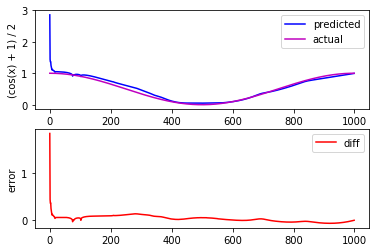

Generating dataset
RMSE: 0.8276164278764624


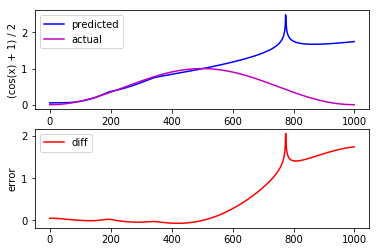

In [11]:
X_test2, y_test2 = generate_static_radial_dataset(task_fn, num_samples, mode='extrapolation', seed=0, cycles=1, theta_offset=1.0*np.pi)
y_pred_nalu2 = nalu_model.predict(X_test2, batch_size=64)
plot_result(y_test2,y_pred_nalu2)

Generating dataset
RMSE: 0.43319647737386435


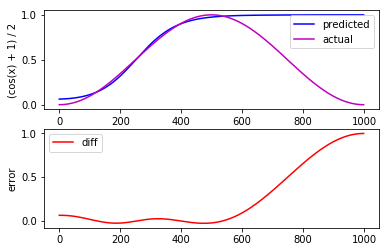

In [12]:
X_test3, y_test3 = generate_static_radial_dataset(task_fn, num_samples, mode='extrapolation', seed=0, cycles=1, theta_offset=1.0*np.pi)
y_pred_simple3 = simple_model.predict(X_test3, batch_size=64)
plot_result(y_test3, y_pred_simple3)